In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from torch.utils.tensorboard import SummaryWriter
 
 
N_CLASSES = 91
FINAL_GRID_SIZE = 9
N_ANCHORS = 1
LAST_KERNEL_DIM = N_CLASSES+N_ANCHORS*5
SCALED_IMG_WIDTH = 288
SCALED_IMG_HEIGHT = 288
 
path2data="./COCO/imgs/train2017"
path2json="./COCO/jsons/annotations/instances_train2017.json"
writer = SummaryWriter('tb/yolo_with_backbone')
 
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

In [ ]:
! mkdir pretrained_models
! wget http://images.cocodataset.org/zips/train2017.zip
! zipsplit -n 3000000000 train2017.zip

In [ ]:
%%bash
for (( i=1; i<=8; i++ ))
do  
    unzip "train2_$i.zip" -d COCO
    rm "train2_$i.zip"
done

In [ ]:
! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
! unzip annotations_trainval2017.zip -d COCO

Archive:  annotations_trainval2017.zip
  inflating: COCO/annotations/instances_train2017.json  
  inflating: COCO/annotations/instances_val2017.json  
  inflating: COCO/annotations/captions_train2017.json  
  inflating: COCO/annotations/captions_val2017.json  
  inflating: COCO/annotations/person_keypoints_train2017.json  
  inflating: COCO/annotations/person_keypoints_val2017.json  


In [2]:
transform = transforms.Compose([
        transforms.Resize((SCALED_IMG_HEIGHT, SCALED_IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform2view = transforms.Compose([
    transforms.Resize((SCALED_IMG_HEIGHT, SCALED_IMG_WIDTH)),
    transforms.ColorJitter(),
    transforms.RandomGrayscale(p=0.15),
    transforms.ToTensor(),
    transforms.RandomErasing(scale=(0.02, 0.10), value='random'),
    transforms.ToPILImage()
])
transform_augmentation = transforms.Compose([
    transforms.RandomGrayscale(p=0.15),
    transform,
    transforms.ColorJitter(),
    transforms.RandomErasing(scale=(0.02, 0.10), value='random')
])

In [5]:
def transform_f (img, annotations, train=True, size=(SCALED_IMG_HEIGHT, SCALED_IMG_WIDTH)):
    if train:
        transform = transform_augmentation
    else:
        transform = transform2view
    w, h = img.size[1], img.size[0]
    scalex = size[1]/w
    scaley = size[0]/h
    if scalex == 1:
        print("eq")
    import copy 
    annotations = copy.deepcopy(annotations)
    for i, ann in enumerate(annotations):
        a = ann['bbox']
        a = (a[0]*scaley, a[1]*scalex, a[2]*scaley, a[3]*scalex)
        annotations[i]['bbox'] = a
    img = transform(img)
    return img, annotations

In [7]:
coco_train = dset.CocoDetection(root = path2data,
                                annFile = path2json,
                                transforms=transform_f)

cats = coco_train.coco.loadCats(coco_train.coco.getCatIds())
cats2 = []
for cat in cats:
    while cat['id'] != len(cats2):
        cats2.append('None')
    cats2.append(cat['name'])
cats = cats2

loading annotations into memory...
Done (t=17.56s)
creating index...
index created!


In [69]:
data_loader = torch.utils.data.DataLoader(coco_train,
                                          batch_size=2,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=batching_func
                                        )

In [11]:
opt = th.optim.Adam([
    {'params':yolo.backbone.parameters(), 'lr':1e-4},
    {'params':yolo.head.parameters()}
])

In [70]:
eps = 100
numsc = 1e-9
i_mbatch = 0
for ep in range(eps):
    for i_mbatch2, (imgs, targets) in enumerate(data_loader):
        i_mbatch += 1
        class_ids, objectness, offsets, normalized_wh = targets
        class_ids, objectness, offsets, normalized_wh = class_ids.to(device), objectness.to(device), offsets.to(device), normalized_wh.to(device)
        preds_class_ids, preds_objectness, preds_offsets, preds_normalized_wh = yolo(imgs.to(device))
        
        indicator = class_ids.sum(dim=1).unsqueeze(1) > 0.5
        loss_c   = bce(class_ids, preds_class_ids, 1, indicator)
        loss_obj = bce(objectness, preds_objectness, 20)/20
        loss_off = bce(offsets, preds_offsets, 1, indicator)
        loss_wh  = (((normalized_wh-preds_normalized_wh)**2) *indicator).sum()/indicator.sum()
        
        loss = loss_c/10 + loss_obj*10 + loss_off/3 + loss_wh*10
        opt.zero_grad()
        loss.backward()
        opt.step()

        if i_mbatch%5==0:
            print(ep, i_mbatch, loss_c.item()/10, loss_obj.item()*10, loss_off.item()/3, loss_wh.item()*10, loss.item())
        if i_mbatch % 750==0:
            save('with_backbone_', ep+1, i_mbatch)

        step = int(ep*120000/64 + i_mbatch)
        writer.add_scalar('loss/class', loss_c, step)
        writer.add_scalar('loss/object', loss_obj, step)
        writer.add_scalar('loss/offset', loss_off, step)
        writer.add_scalar('loss/bbox_wh', loss_wh, step)



RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 1.96 GiB total capacity; 1019.81 MiB already allocated; 7.75 MiB free; 1.02 GiB reserved in total by PyTorch)

In [ ]:
save('with_backbone_', ep, i_mbatch)

In [12]:
load('with_backbone_', 2, 22500, 1)
# del yolo

torch.Size([3, 480, 640])


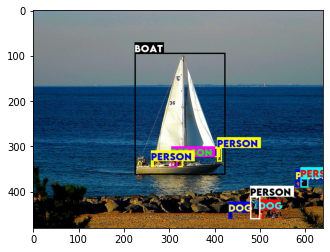

In [44]:
import random
import torch
ii = random.randint(0, 10000)
coco_train.transforms = None
img, ann = coco_train[ii]
coco_train.transforms = transform_f
visualize_img(img, ann)